<a href="https://colab.research.google.com/github/Bhishmdt/Yandex/blob/main/11_seminar_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice: simple question answering
![img](https://www.cs.upc.edu/~mlatifi/index_files/qa-logo.jpg)

Today we're going to build a retrieval-based question answering model with metric learning models.

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [ ]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [ ]:
!pip install -q transformers
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week11_conversation/data.py -O data.py
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log

import data
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = data.build_dataset('./squad-v2.0.json')

--2021-03-02 03:14:41--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week11_conversation/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3553 (3.5K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]   3.47K  --.-KB/s    in 0s      

2021-03-02 03:14:41 (64.8 MB/s) - ‘data.py’ saved [3553/3553]



In [ ]:
pid, question, options, correct_indices, wrong_indices = train.iloc[1000]
print('QUESTION', question, '\n')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION What did one of the treaties between the Tang and Tibet help fix? 

[ ] Tibet was once a strong power contemporaneous with Tang China (618–907).
[ ] Until the Tibetan Empire's collapse in the 9th century, it was the Tang's major rival in dominating Inner Asia.
[v] The Yarlung rulers of Tibet also signed various peace treaties with the Tang, culminating in a treaty in 821 that fixed the borders between Tibet and China.


### Pre-trained BERT
_(but you guessed it)_

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. We will default to the good ol' [BERT](https://arxiv.org/abs/1810.04805), though, you are free to use any [other model](https://huggingface.co/models) as you see fit.


In [ ]:
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

In [ ]:
bert.pooler.parameters()

<generator object Module.parameters at 0x7f68a1778c50>

In [ ]:
full_parameters = sum(p.numel() for p in bert.encoder.layer[0].parameters())

In [ ]:
full_parameters

7087872

In [ ]:
# for params in bert.embeddings.parameters():
#   params.requires_grad = False

In [ ]:
# count = 0
# for l in bert.encoder.layer:
#   if count > 0:
#     for param in l.parameters():
#       param.requires_grad = False
#   count += 1

In [ ]:
full_parameters = sum(p.numel() for p in bert.parameters())

In [ ]:
full_parameters

109482240

In [ ]:
trained_parameters = sum(p.numel() for p in bert.parameters() if p.requires_grad)

In [ ]:
trained_parameters

109482240

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
bert.to(device);

In [ ]:
# just a reminder: here's how it works
dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

with torch.no_grad():
    batch_tensors = tokenizer(dummy_lines, padding=True, truncation=True, return_tensors="pt", max_length=128)
    batch_tensors.to(device)
    out = bert(**batch_tensors)
    
token_embs = out.last_hidden_state    
mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

In [ ]:
naive_phrase_embs.shape

torch.Size([5, 768])

In [ ]:
token_embs[0]

tensor([[ 0.1869,  0.4781,  0.9566,  ...,  0.1477,  0.4116, -0.4876],
        [ 0.5947,  0.2328,  1.1413,  ...,  0.2019,  0.2265, -0.5749],
        [ 0.6997,  0.5144,  0.9565,  ...,  0.1015,  0.4154, -0.9413],
        ...,
        [ 0.4017,  0.2547,  0.8243,  ...,  0.1094,  0.4788, -0.5567],
        [ 0.2154,  0.2356,  0.7428,  ...,  0.2806,  0.6748, -0.5706],
        [ 0.3124,  0.4335,  0.8917,  ...,  0.2704,  0.5135, -0.6426]],
       device='cuda:0')

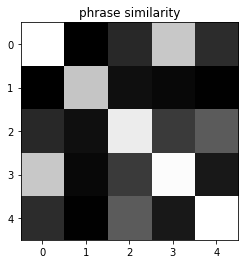

In [ ]:
plt.title('phrase similarity')
plt.imshow((naive_phrase_embs @ naive_phrase_embs.t()).cpu().data.numpy(), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors. 

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the pre-trained encoder.




In [ ]:
class Vectorizer(nn.Module):
    def __init__(self, hid_size=256, bert=bert):
        """ A small feedforward network on top of pre-trained encoder. 2-3 layers should be enough """
        super().__init__()
        self.bert = bert
        self.hid_size = hid_size
        
        # define a few layers to be applied on top of pre-trained BERT
        # note: please make sure your final layer comes with _linear_ activation
        self.drop = nn.Dropout(0.3)
        self.head = nn.Sequential(
            nn.Linear(768, hid_size),
            nn.LeakyReLU(),
            # nn.Linear(hid_size, hid_size),
            # nn.LeakyReLU(),
            # nn.Linear(hid_size, hid_size)
        )

        

    def forward(self, input_phrases):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: a list of strings, [batch_size]
        :returns: predicted phrase vectors, [batch_size, output_size]
        
        Note: you may want to use dropouts.
        if self.training:
          <something>
        
        Note 2: you may also want to use with torch.no_grad to avoid training BERT for your first attempts
        
        """
        
        # In fact, please DO use at least 10% dropout!
        #with torch.no_grad():
        batch_tensors = tokenizer(input_phrases, padding=True, truncation=True, return_tensors="pt", max_length=256)
        batch_tensors.to(device)
        out = bert(**batch_tensors)
        token_embs = out.last_hidden_state    

        token_embs = self.drop(token_embs)
        mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
        naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)
        return self.head(naive_phrase_embs)

In [ ]:
question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer().to(device)

In [ ]:
question_vectorizer.train(False)
out1 = question_vectorizer(dummy_lines)
out2 = question_vectorizer(dummy_lines)
assert tuple(out1.shape) == (5, question_vectorizer.hid_size)
assert torch.allclose(out1, out2, atol=1e-5, rtol=0), "Make sure your model disables dropout if training == False"
print("Well done!")

Well done!


### Training: minibatches

Our model learns on triples $(q, a^+, a^-)$: 
* q - __q__uestion
* (a+) - correct __a__nswer
* (a-) - wrong __a__nswer 

Below you will find a generator that samples such triples from data.

In [ ]:
def similarity(a, b):
    """ Dot product as a similarity function """
    
    #return util.pytorch_cos_sim(a,b)
    return torch.einsum("bc, bc ->b", a, b)

def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """ 
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: you can compute max(0, *) using torch.relu :)
    """
    sim_positive = similarity(question_vectors, correct_answer_vectors)
    sim_negative = similarity(question_vectors, wrong_answer_vectors)
    return torch.relu(delta - sim_positive + sim_negative)

In [ ]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])
            # wrong_answers = []
            # for i, row in batch.iterrows():
            #   with torch.no_grad():
            #     batch_tensors = tokenizer(row['options'], padding=True, truncation=True, return_tensors="pt", max_length=128)
            #     batch_tensors.to(device)
            #     out = bert(**batch_tensors)    
            #     token_embs = out.last_hidden_state    
            #     mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
            #     naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

            #     question_tensor = tokenizer(row['question'], padding=True, truncation=True, return_tensors="pt", max_length=128)
            #     question_tensor.to(device)
            #     out = bert(**question_tensor)
            #     token_embs = out.last_hidden_state    
            #     mask = question_tensor['attention_mask'][..., None].to(torch.float32)
            #     question_embs = (token_embs * mask).sum(1) / mask.sum(1)
                
            #     question_embs = question_embs.repeat(len(row['options']), 1)
            #     t = similarity(question_embs, naive_phrase_embs).cpu().numpy()
            #     for j in range(len(row['options'])):
            #       if j in row['correct_indices']:
            #         t[j]=float('inf')#.append(similarity(question_embs, naive_phrase_embs[j].unsqueeze(0)).cpu().numpy())
            #       # else:
            #       #   t.append(float('-inf'))
            #   w = np.argmin(t)
            #   wrong_answers.append(row['options'][w])
            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': np.array(wrong_answers),
            }
        if not cycle:
            break

In [ ]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print(dummy_batch)

{'questions': array(['What action is made much more difficult for boards that have a conformal coating?',
       'Along with MeadWestvaco, what Fortune 500 company is based in Richmond?',
       'What was the result of the British attack on Ft Duquesne?'],
      dtype=object), 'correct_answers': array(['The chief disadvantage of conformal coatings is that servicing of the board is rendered extremely difficult.',
       'Dominion Resources and MeadWestvaco, Fortune 500 companies, are headquartered in the city, with others in the metropolitan area.',
       'In July British Major General Edward Braddock led about 2,000 army troops and provincial militia on an expedition to retake Fort Duquesne, but the expedition ended in disastrous defeat.'],
      dtype='<U185'), 'wrong_answers': array(['Another technique for applying a conformal coating is for plastic to be sputtered onto the PCB in a vacuum chamber.',
       'The city is home to both the United States Court of Appeals for the Fourth 

### Training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_. 

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/). 

In [ ]:
dummy_v1 = torch.tensor([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=torch.float32)
dummy_v2 = torch.tensor([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=torch.float32)
dummy_v3 = torch.tensor([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=torch.float32)

assert np.allclose(similarity(dummy_v1, dummy_v2).data.numpy(), [7.11, -1.84])
assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy(), [0.0, 3.88])

Once loss is working, let's train our model by our usual means.

In [ ]:
# we also compute recall: the rate at which a^+ is closer to q than a^-
def get_recall(questions, correct_answers, wrong_answers):
    
    v_questions = question_vectorizer(list(questions))
    v_correct = answer_vectorizer(list(correct_answers))
    v_incorrect = answer_vectorizer(list(wrong_answers))

    correct_is_closer = similarity(v_questions, v_correct) > similarity(v_questions, v_incorrect)
    
    return torch.mean(correct_is_closer.to(torch.float32)).item()

In [ ]:
dummy_batch

{'correct_answers': array(['The chief disadvantage of conformal coatings is that servicing of the board is rendered extremely difficult.',
        'Dominion Resources and MeadWestvaco, Fortune 500 companies, are headquartered in the city, with others in the metropolitan area.',
        'In July British Major General Edward Braddock led about 2,000 army troops and provincial militia on an expedition to retake Fort Duquesne, but the expedition ended in disastrous defeat.'],
       dtype='<U185'),
 'questions': array(['What action is made much more difficult for boards that have a conformal coating?',
        'Along with MeadWestvaco, what Fortune 500 company is based in Richmond?',
        'What was the result of the British attack on Ft Duquesne?'],
       dtype=object),
 'wrong_answers': array(['Another technique for applying a conformal coating is for plastic to be sputtered onto the PCB in a vacuum chamber.',
        'The city is home to both the United States Court of Appeals for th

In [ ]:
# make sure it works
get_recall(**dummy_batch)

0.6666666865348816

### Training loop

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ DSSM training may be very sensitive to the choice of batch size. Small batch size may decrease model quality.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__. 

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and test is for final eval only.


In [ ]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm


# Initialize model, optimizers, anything else you want
all_layers = nn.ModuleList([question_vectorizer, answer_vectorizer])
#opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, all_layers.parameters()), lr=0.003)
opt = torch.optim.AdamW(all_layers.parameters(), lr=0.00001)

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=16, cycle=True)
loss_history = []
dev_recall_history = []

In [ ]:
#all_layers

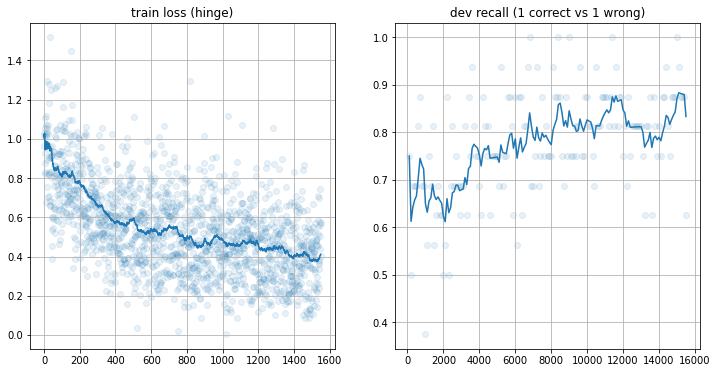

KeyboardInterrupt: ignored

In [ ]:
# infinite training loop. Stop it manually or implement early stopping

for batch in iterate_minibatches(train, batch_size=16, cycle=True):
    # Perform one training step
    all_layers.train(True)
    v_questions = question_vectorizer(list(batch['questions']))
    v_correct = answer_vectorizer(list(batch['correct_answers']))
    v_incorrect = answer_vectorizer(list(batch['wrong_answers']))
    
    
    loss_t = compute_loss(v_questions, v_correct, v_incorrect).mean()
    loss_t.backward()
    nn.utils.clip_grad_norm_(all_layers.parameters(), max_norm=1.0)
    opt.step()
    opt.zero_grad()
    loss_history.append(float(loss_t))
    
    if len(loss_history) % 10 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        
        all_layers.train(False)
        recall_t = get_recall(**dev_batch)
        
        dev_recall_history.append(recall_t)
    
    if len(loss_history) % 10 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    

In [ ]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.85, "Please train for at least 85% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.85625
Well done!


# Final evaluation (1 point)

Let's see how well does our model perform on actual question answering. 

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [ ]:
# optional: any additional preparations, e.g. build index
# <...>

def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    with torch.no_grad():
      q = question_vectorizer(question)
      

      a = answer_vectorizer(possible_answers)
      
    q = q.repeat(len(possible_answers), 1)
    t = similarity(q, a).cpu().numpy()
    
    return np.argmax(t)

In [ ]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in tqdm(test[['question', 'options']].iterrows(), total=len(test))
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

In [ ]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))
    
    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT", 
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [ ]:
for i in [1, 100, 1000, 2000, 3000, 4000, 5000]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

Q: Which three countries did Beyonce's song "Work It Out" achieve top ten status?

#0: [*] In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.
#1: [ ] Beyoncé released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.
#2: [ ] In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love with.
#3: [ ] The film received mixed reviews from critics but grossed $30 million in the U.S. Beyoncé released "Fighting Temptation" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film.
#4: [ ] Another of Beyoncé's contributions to the soundtrack, "Summertime", fared better on the US charts.

In [ ]:
question = "How many Special Police protected the relay event?" # your question here!
possible_answers = [
                    'Malaysia: The event was held in the capital city, Kuala Lumpur, on April 21.',
                    'The 16.5 km long-relay began from the historic Independence Square, passed in front of several city landmarks before coming to an end at the iconic Petronas Twin Towers.',
                    'Among the landmarks the Olympic flame passed next to were the Parliament House, National Mosque, KL Tower and Merdeka Stadium.',
                    'A team of 1000 personnel from the Malaysian police Special Action Squad guarded the event and escorted the torchbearers.',
                    'The last time an Olympic torch relay was held in Malaysia was the 1964 Tokyo edition.',
                    ]
predicted_answer = select_best_answer(question, possible_answers)

draw_results(question, possible_answers,
             predicted_answer, [3])

Q: How many Special Police protected the relay event?

#0: [ ] Malaysia: The event was held in the capital city, Kuala Lumpur, on April 21.
#1: [ ] The 16.5 km long-relay began from the historic Independence Square, passed in front of several city landmarks before coming to an end at the iconic Petronas Twin Towers.
#2: [ ] Among the landmarks the Olympic flame passed next to were the Parliament House, National Mosque, KL Tower and Merdeka Stadium.
#3: [*] A team of 1000 personnel from the Malaysian police Special Action Squad guarded the event and escorted the torchbearers.
#4: [ ] The last time an Olympic torch relay was held in Malaysia was the 1964 Tokyo edition.

Verdict: CORRECT (ref: [3])




### Bonus tasks

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

### 1.  Hard Negatives (3+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.


### 2. Bring Your Own Model (3+ pts)
In addition to BERT, one can also train a new model.
* You name it: convolutions, RNN, self-attention (beware, it may need pre-training data)
* Combine multple bert-like models
* Monitor overfitting and use dropout / word dropout to improve performance

* hard negatives (strategies: hardest, hardest farter than current, randomized)
* train model on the full dataset to see if it can mine answers to new questions over the entire wikipedia. Use approximate nearest neighbor search for fast lookup.


### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib). 
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.
